scikit-learn version: 1.6.1

All columns: ['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID', 'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID', 'Salary', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB', 'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus', 'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource', 'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30', 'Absences']
Using target_col = Termd
Termd
0    207
1    104
Name: count, dtype: int64 

Epoch 1/100
7/7 - 4s - 555ms/step - accuracy: 0.4495 - auc: 0.3807 - loss: 0.7067 - val_accuracy: 0.6000 - val_auc: 0.5205 - val_loss: 0.6818
Epoch 2/100
7/7 - 0s - 51ms/step - accuracy: 0.7071 - auc: 0.6899 - loss: 0.6568 - val_accuracy: 0.7000 - val_auc: 0.8369 - val_loss: 0.6489
Epoch 3/100
7/7 - 0s - 18ms/step - accuracy: 0.7525

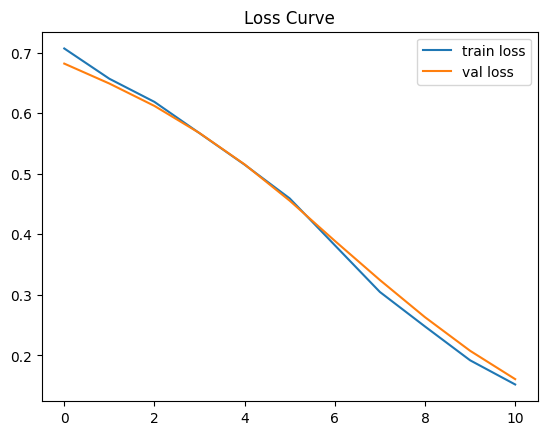

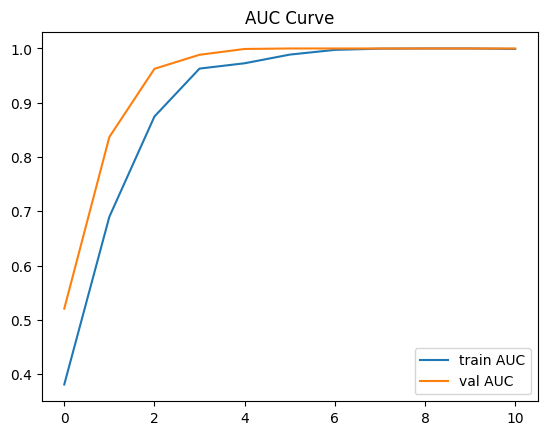

In [ ]:
# 1. Imports and seed setting
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("scikit-learn version:", sklearn.__version__)

# 2. Load dataset
df = pd.read_csv('/mnt/data/HRDataset_v14.csv')

# 3. Inspect columns
print("\nAll columns:", df.columns.tolist())

# 4. Choose the correct target column for “did they quit?”
#    In your CSV it’s called 'Termd' (1 = terminated/quitted, 0 = still active)
target_col = 'Termd'
print("Using target_col =", target_col)
print(df[target_col].value_counts(dropna=False), "\n")

# 5. Drop columns with >50% missing, plus pure identifiers
thresh = len(df) * 0.5
df = df.dropna(axis=1, thresh=thresh)
for col in ['Employee_Name', 'EmpID', 'ManagerName', 'ManagerID']:
    if col in df.columns:
        df = df.drop(columns=col)

# 6. Separate numeric vs categorical features
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# 7. Impute missing values (no inplace chaining)
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

# 8. One-hot encode categoricals & scale numericals
enc = OneHotEncoder(drop='first', sparse_output=False)
X_cat = pd.DataFrame(
    enc.fit_transform(df[cat_cols]),
    columns=enc.get_feature_names_out(cat_cols),
    index=df.index
)

scaler = StandardScaler()
X_num = pd.DataFrame(
    scaler.fit_transform(df[num_cols]),
    columns=num_cols,
    index=df.index
)

# 9. Assemble feature matrix and target vector
X = pd.concat([X_num, X_cat], axis=1)
y = df[target_col].astype(int).values

# 10. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.20,
    random_state=SEED
)

# 11. Build & compile the Keras model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# 12. Train with early stopping on validation AUC
es = callbacks.EarlyStopping(
    monitor='val_auc', mode='max',
    patience=5, restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# 13. Evaluate on test set
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}  Test Acc: {acc:.4f}  Test AUC: {auc:.4f}")

# 14. Detailed metrics
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# 15. Plot training curves
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss Curve')

plt.figure()
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.legend()
plt.title('AUC Curve')

plt.show()


Columns: ['Age', 'MonthlyIncome', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
→ Using target column: Attrition
Attrition
No     1233
Yes     237
Name: count, dtype: int64 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,185 (20.25 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
30/30 - 4s - 149ms/step - accuracy: 0.6191 - auc: 0.5133 - loss: 0.6475 - val_accuracy: 0.8305 - val_auc: 0.5672 - val_loss: 0.4620
Epoch 2/100
30/30 - 0s - 7ms/step - accuracy: 0.8394 - auc: 0.5844 - loss: 0.4499 - val_accuracy: 0.8305 - val_auc: 0.6908 - val_loss: 0.4233
Epoch 3/100
30/30 - 0s - 10ms/step - accuracy: 0.8404 - auc: 0.6438 - loss: 0.4303 - val_accuracy: 0.8305 - val_auc: 0.7625 - val_loss: 0.4022
Epoch 4/100
30/30 - 0s - 6ms/step - accuracy: 0.8436 - auc: 0.6991 - loss: 0.4045 - val_accuracy: 0.8305 - val_auc: 0.7925 - val_loss: 0.3883
Epoch 5/100
30/30 - 0s - 9ms/step - accuracy: 0.8436 - auc: 0.7125 - loss: 0.4053 - val_accuracy: 0.8305 - val_auc: 0.8118 - val_loss: 0.3759
Epoch 6/100
30/30 - 0s - 6ms/step - accuracy: 0.8447 - auc: 0.7675 - loss: 0.3770 - val_accuracy: 0.8305 - val_auc: 0.8268 - val_loss: 0.3655
Epoch 7/100
30/30 - 0s - 10ms/step - accuracy: 0.8468 - auc: 0.7852 - loss: 0.3687 - val_accuracy: 0.8347 - val_auc: 0.8330 - val_loss: 0.3545
Ep

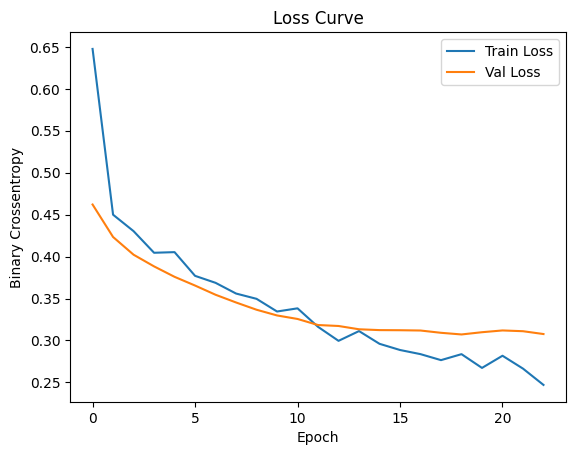

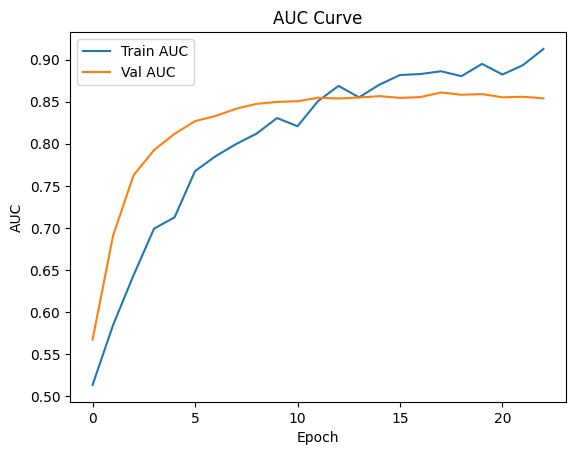

In [ ]:
# === Employee Retention Prediction Pipeline ===

# 1. Imports & seed setting
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2. Load your CSV
df = pd.read_csv('/mnt/data/2nd Human_Resources.csv')

# 3. Inspect columns
print("Columns:", df.columns.tolist())

# 4. Detect which column is our target
if 'Attrition' in df.columns:
    target_col = 'Attrition'
    target_map = {'Yes': 1, 'No': 0}
elif 'Termd' in df.columns:
    target_col = 'Termd'
    # assume Termd already 1/0
    target_map = {0: 0, 1: 1}
else:
    raise KeyError("Couldn't find 'Attrition' or 'Termd' in your DataFrame")

print(f"→ Using target column: {target_col}")
print(df[target_col].value_counts(dropna=False), "\n")

# 5. Drop very sparse columns (>50% missing) and any identifier fields
df = df.dropna(axis=1, thresh=len(df)*0.5)
for id_col in ['Employee_Name','EmpID','ManagerID','ManagerName']:
    if id_col in df.columns:
        df.drop(columns=id_col, inplace=True)

# 6. Split into numeric vs. categorical feature lists
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)

# 7. Impute missing values (no inplace chaining)
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

# 8. One-hot encode categoricals, and standard-scale numericals
enc = OneHotEncoder(drop='first', sparse_output=False)
X_cat = pd.DataFrame(
    enc.fit_transform(df[cat_cols]),
    columns=enc.get_feature_names_out(cat_cols),
    index=df.index
)

scaler = StandardScaler()
X_num = pd.DataFrame(
    scaler.fit_transform(df[num_cols]),
    columns=num_cols,
    index=df.index
)

# 9. Assemble final feature matrix X and target vector y
X = pd.concat([X_num, X_cat], axis=1)
y = df[target_col].map(target_map).astype(int).values

# 10. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.20,
    random_state=SEED
)

# 11. Build the Keras model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

# 12. Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# 13. Model summary
model.summary()

# 14. Train with EarlyStopping on validation AUC
es = callbacks.EarlyStopping(
    monitor='val_auc', mode='max',
    patience=5, restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# 15. Evaluate on the test set
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}  Test Accuracy: {acc:.4f}  Test AUC: {auc:.4f}")

# 16. Predictions & detailed metrics
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# 17. Plot training curves
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Binary Crossentropy')
plt.title('Loss Curve'); plt.legend()

plt.figure()
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.title('AUC Curve'); plt.legend()

plt.show()


In [ ]:
print("I believe the 2nd link by Alison is the correct file")

I believe the 2nd link by Alison is the correct file
